In [1]:
###------PREPROCESSING THE DATA-------------
import json
import pickle
import time
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english')) 

default_pattern =  r"""(?x)                  
                        (?:[A-Z]\.)+          
                        |\$?\d+(?:\.\d+)?%?    
                        |\w+(?:[-']\w+)*      
                    """
with open('train.json') as json_file:
    data = json.load(json_file)
data_length = 20000

essays = []
age = []
gender = []
gender_label  = []
original_data = []

for i in range(data_length):
  poster_gender = data[i]['gender']
  poster_age = int(data[i]['age'])
  post = data[i]['post']
  original_data.append(post)
  tokens = regexp_tokenize(post, default_pattern)

  #f_post = [w for w in tokens if not w in stop_words]

  essays.append(tokens)
  age.append(poster_age)
  gender.append(poster_gender)
  if poster_gender == 'male':
    gender_label.append(0)
  else:
    gender_label.append(1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
###-----CREATING POSSESSIVE FEATURES--------
def possessives_features(posts):
  total_dict = {}
  count_my = {}
  count_others = {}

  index = 0

  for post in posts:
    tag = 0
    for word in post:
      if tag == 1 and word.lower() not in total_dict:
        total_dict[word.lower()] = index
        count_my[word.lower()] = 1
        count_others[word.lower()] = 0
        index += 1
      elif tag == 1 and word.lower() in total_dict:
        count_my[word.lower()] += 1
      elif tag == 2 and word.lower() not in total_dict:
        total_dict[word.lower()] = index
        count_others[word.lower()] = 1
        count_my[word.lower()] = 0
        index += 1
      elif tag == 2 and word.lower() in total_dict:
        count_others[word.lower()] += 1

      if word.lower() == 'my':
        tag = 1
      elif word.lower() == 'theirs' or word.lower() == 'his' or word.lower() == 'hers' or word.lower() == 'yours':
        tag = 2
      else:
        tag = 0
  
  my_feature = []
  other_feature = []
  dict_len = len(total_dict)
  print('dict len is',dict_len, 'index', index)

  for post in posts:
    tag = 0
    feature1 = np.zeros(dict_len)
    feature2 = np.zeros(dict_len)
    for word in post:
      if tag == 1:
        idx = total_dict[word.lower()]
        feature1[idx] += 1
      elif tag == 2:
        idx = total_dict[word.lower()]
        feature2[idx] += 1

      if word.lower() == 'my':
        tag = 1
      elif word.lower() == 'theirs' or word.lower() == 'his' or word.lower() == 'hers' or word.lower() == 'yours':
        tag = 2
      else:
        tag = 0
      my_feature.append(feature1)
      other_feature.append(feature2)
  return my_feature, other_feature, total_dict

In [0]:
###----SVM WITH POSSESSIVES-----------
import sklearn
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#classifier = svm.SVC(max_iter=5000)
trainlength = round(0.8*len(essays))

my_feature, other_feature, total_dict = possessives_features(essays)
print('done with dictionary')
features = my_feature
Xtrain = np.asarray(features[:trainlength])
Ytrain = np.asarray(gender_label[:trainlength])
print('done with split')

#Xtrain = Xtrain.reshape(-1, 1)

classifier = LogisticRegression(random_state=0).fit(Xtrain, Ytrain)
#classifier.fit(Xtrain, Ytrain)
print('done with fit')
Xtest = np.asarray(features[trainlength:])
Ytest = np.asarray(gender_label[trainlength:])

#Xtest = Xtest.reshape(-1, 1)
print('done with split')
pred = classifier.predict(Xtest)
print(accuracy_score(Ytest, pred))

dict len is 8248 index 8248
done with dictionary
done with split


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


done with fit


In [28]:
###-----------CREATING POS FEATURES-------------
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
tagset = nltk.load('help/tagsets/upenn_tagset.pickle')
no_tags = len(tagset.keys())
index = 0
tagdict = {}
for tag in tagset.keys():
  tagdict[tag] = index
  index = index+1

def POS(essays):
  pos_features = []
  for post in essays:
    pos = nltk.pos_tag(post)
    feature = np.zeros(no_tags)
    for elem in pos:
      tag = elem[1]
      index = tagdict[tag]
      feature[index] += 1
    pos_features.append(feature)
  return pos_features

pos_features = POS(essays)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [0]:
###-------CREATING F MEASURE FEATURES-----------
### Reference: https://medium.com/@gianpaul.r/tokenization-and-parts-of-speech-pos-tagging-in-pythons-nltk-library-2d30f70af13b
def f(pos_features, tagdict):
  f_features = []
  for feature in pos_features:
    ##NN, NNS, NNP, NNPS
    i0 = tagdict['NN']
    i1 = tagdict['NNS']
    i2 = tagdict['NNP']
    i3 = tagdict['NNPS']
    noun = feature[i0]+feature[i1]+feature[i2]+feature[i3]

    #JJ,JJR,JJS
    i4 = tagdict['JJ']
    i5 = tagdict['JJR']
    i6 = tagdict['JJS']
    adj = feature[i4]+feature[i5]+feature[i6]

    #IN
    i7 = tagdict['IN']
    prep = feature[i7]

    #DT,WDT, PDT(?)
    i8 = tagdict['DT']
    i9 = tagdict['WDT']
    art = feature[i8]+feature[i9]

    #PRP, PRP$
    i10 = tagdict['PRP']
    i11 = tagdict['PRP$']
    pron = feature[i10]+feature[i11]

    #VB,VBD, VBG, VBN, VBP, VBZ
    i12 = tagdict['VB']
    i13 = tagdict['VBD']
    i14 = tagdict['VBN']
    i15 = tagdict['VBP']
    i16 = tagdict['VBZ']
    verb = feature[i12]+feature[i13]+feature[i14]+feature[i15]+feature[i16]

    #RB,RBR,RBS
    i17 = tagdict['RB']
    i18 = tagdict['RBR']
    i19 = tagdict['RBS']
    adv =  feature[i17]+feature[i18]+feature[i19]

    #UH
    i20 = tagdict['UH']
    inter = feature[i20]
    num = 0.5*((noun+adj+prep+art)-(verb+adv+inter)+100)
    f_features.append(num)
  return f_features

f_feature = f(pos_features, tagdict)

In [0]:
###----CREATING POS SEQUENCE FEATURES (Bigram)----------------
index = 0
tagseq = {}
for tag1 in tagset.keys():
  for tag2 in tagset.keys():
    tog = tag1+" "+tag2
    if tog not in tagseq:
      tagseq[tog] = index
      index = index+1

def pos_seq(essays, tagseq):
  pos_seq_features = []
  tagseqlen = len(tagseq)
  for post in essays:
    pos = nltk.pos_tag(post)
    feature = np.zeros(tagseqlen)
    for i in range(len(pos)-1):
      tag1 = pos[i]
      tag2 = pos[i+1]
      tag1 = tag1[1]
      tag2 = tag2[1]
      tog = tag1+" "+tag2
      index = tagseq[tog]
      feature[index] += 1
    pos_seq_features.append(feature)
  return pos_seq_features
  
pos_seq_features = pos_seq(essays, tagseq) 

In [0]:
###----_VISUALIZATION------------
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [0]:
def create_plot(labels, male_means, female_means, title, flag, size, save):
  x = np.arange(len(labels))  # the label locations
  width = 0.35  # the width of the bars

  fig, ax = plt.subplots()
  fig.set_size_inches(size, size)
  rects1 = ax.bar(x - width/2, male_means, width, label='Male')
  rects2 = ax.bar(x + width/2, female_means, width, label='Female')

# Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Scores')
  ax.set_title(title)
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  if flag == 1:
    autolabel(rects1)
    autolabel(rects2)

  if save == 1:
    fig.savefig('test2png.png', dpi=100)

  fig.tight_layout()

  plt.show()

works


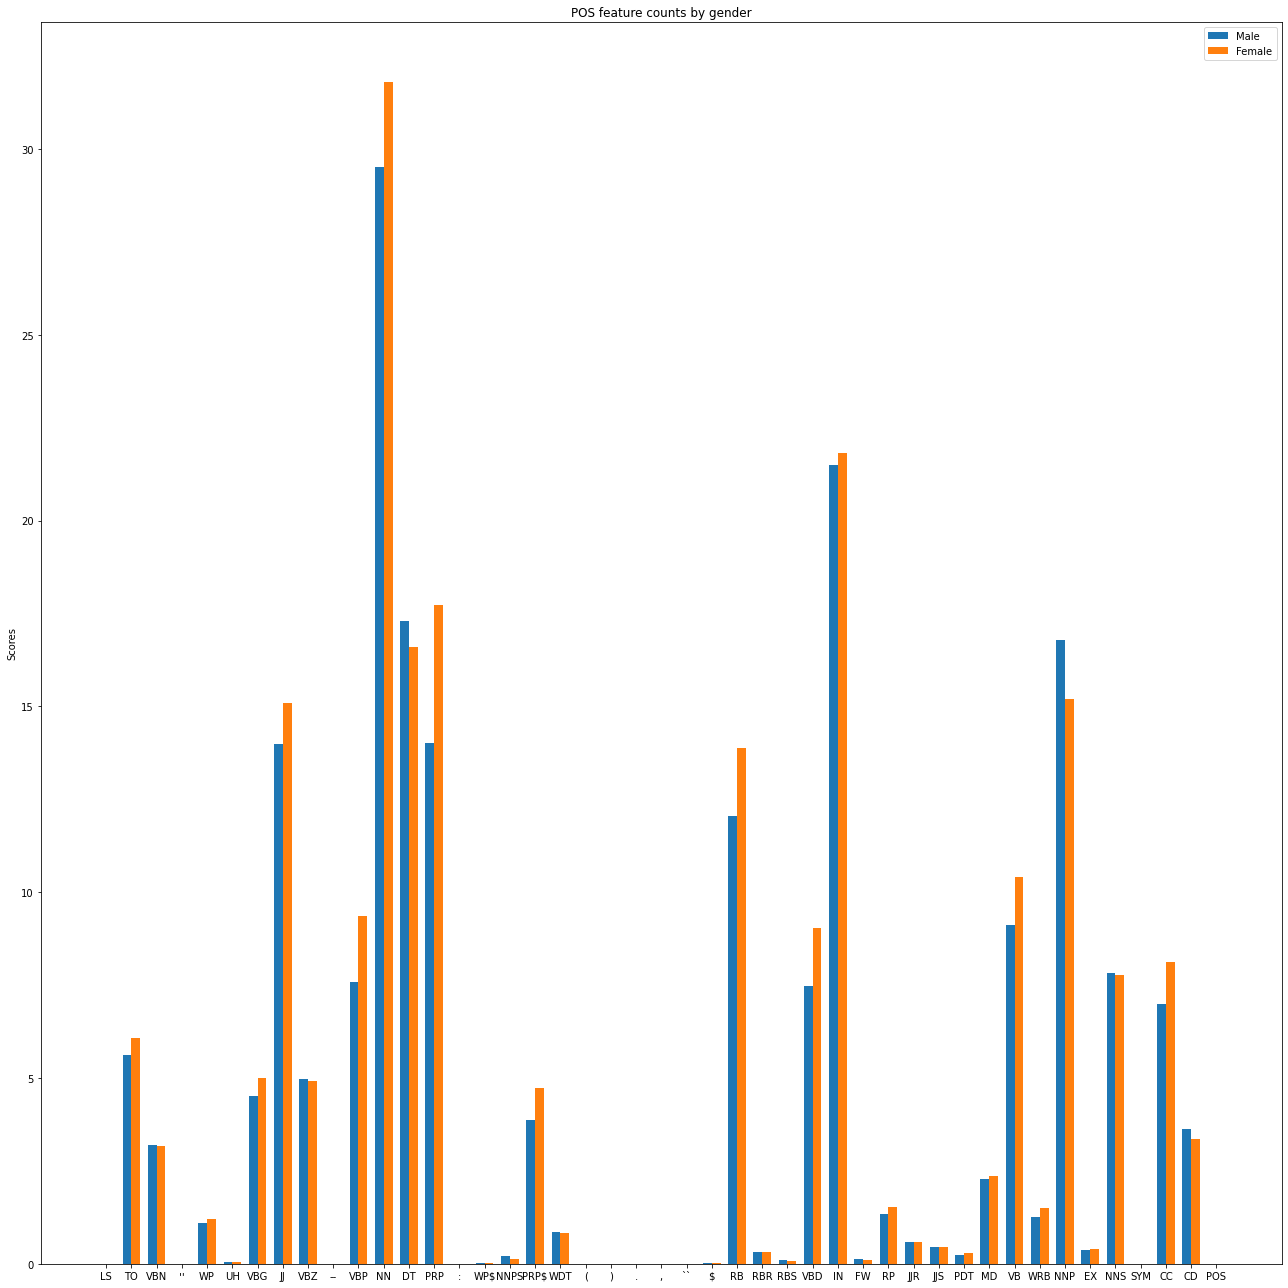

In [26]:
###-------POS FEATURES VISUALIZATION----------
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

labels = []
length = len(tagdict)
male_means = np.zeros(length)
female_means = np.zeros(length)

for label in tagdict:
  labels.append(label)

male_count = 0
female_count = 0
for idx in range(len(essays)):
  if gender_label[idx] == 0: #male
    male_means += np.asarray(pos_features[idx])
    male_count += 1
  else:
    female_means += np.asarray(pos_features[idx])
    female_count += 1

male_means = male_means/male_count
female_means = female_means/female_count

male_means = list(male_means)
female_means = list(female_means)

create_plot(labels, male_means, female_means, 'POS feature counts by gender',1, 18,0)


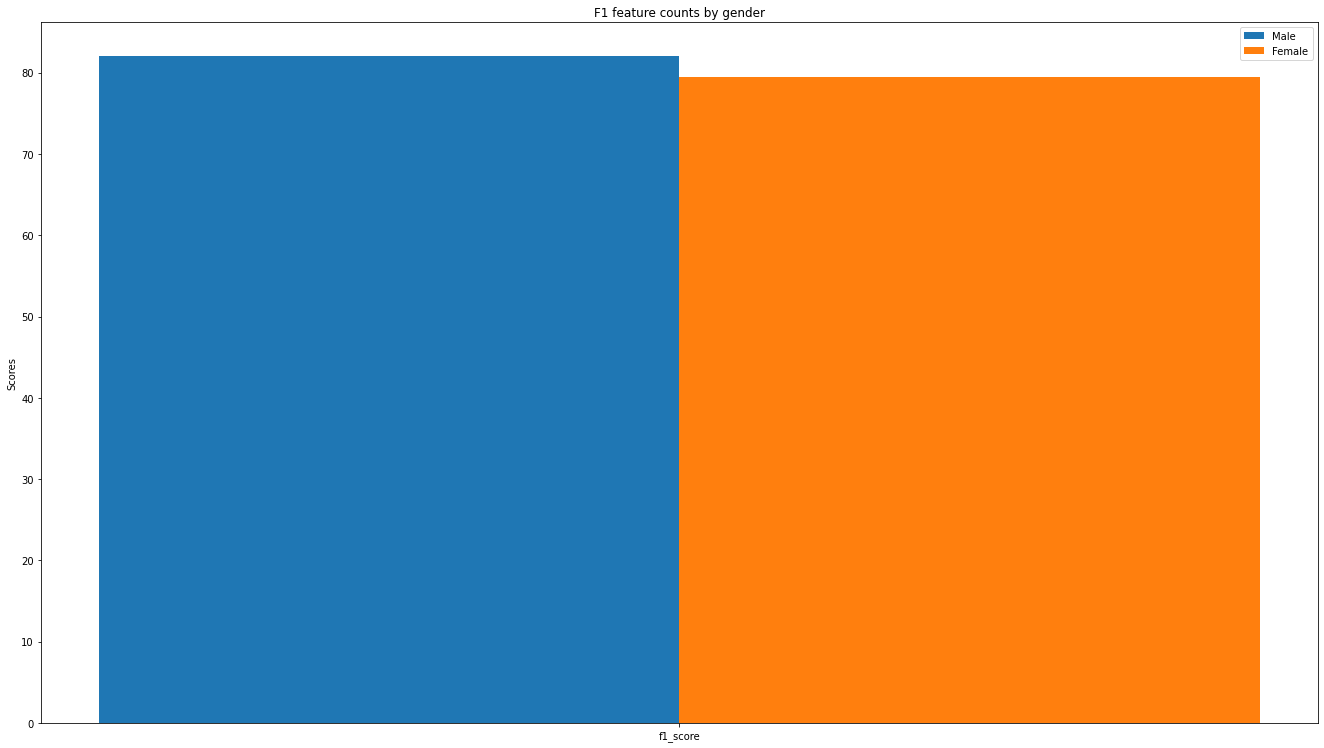

In [20]:
###-------F1 FEATURES VISUALIZATION----------
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

labels = []
male_means = np.zeros(1)
female_means = np.zeros(1)
labels.append('f1_score')

male_count = 0
female_count = 0
for idx in range(len(essays)):
  if gender_label[idx] == 0: #male
    male_means += np.asarray(f_feature[idx])
    male_count += 1
  else:
    female_means += np.asarray(f_feature[idx])
    female_count += 1

male_means = male_means/male_count
female_means = female_means/female_count

male_means = list(male_means)
female_means = list(female_means)

create_plot(labels, male_means, female_means, 'F1 feature counts by gender', 0, 5, 0)

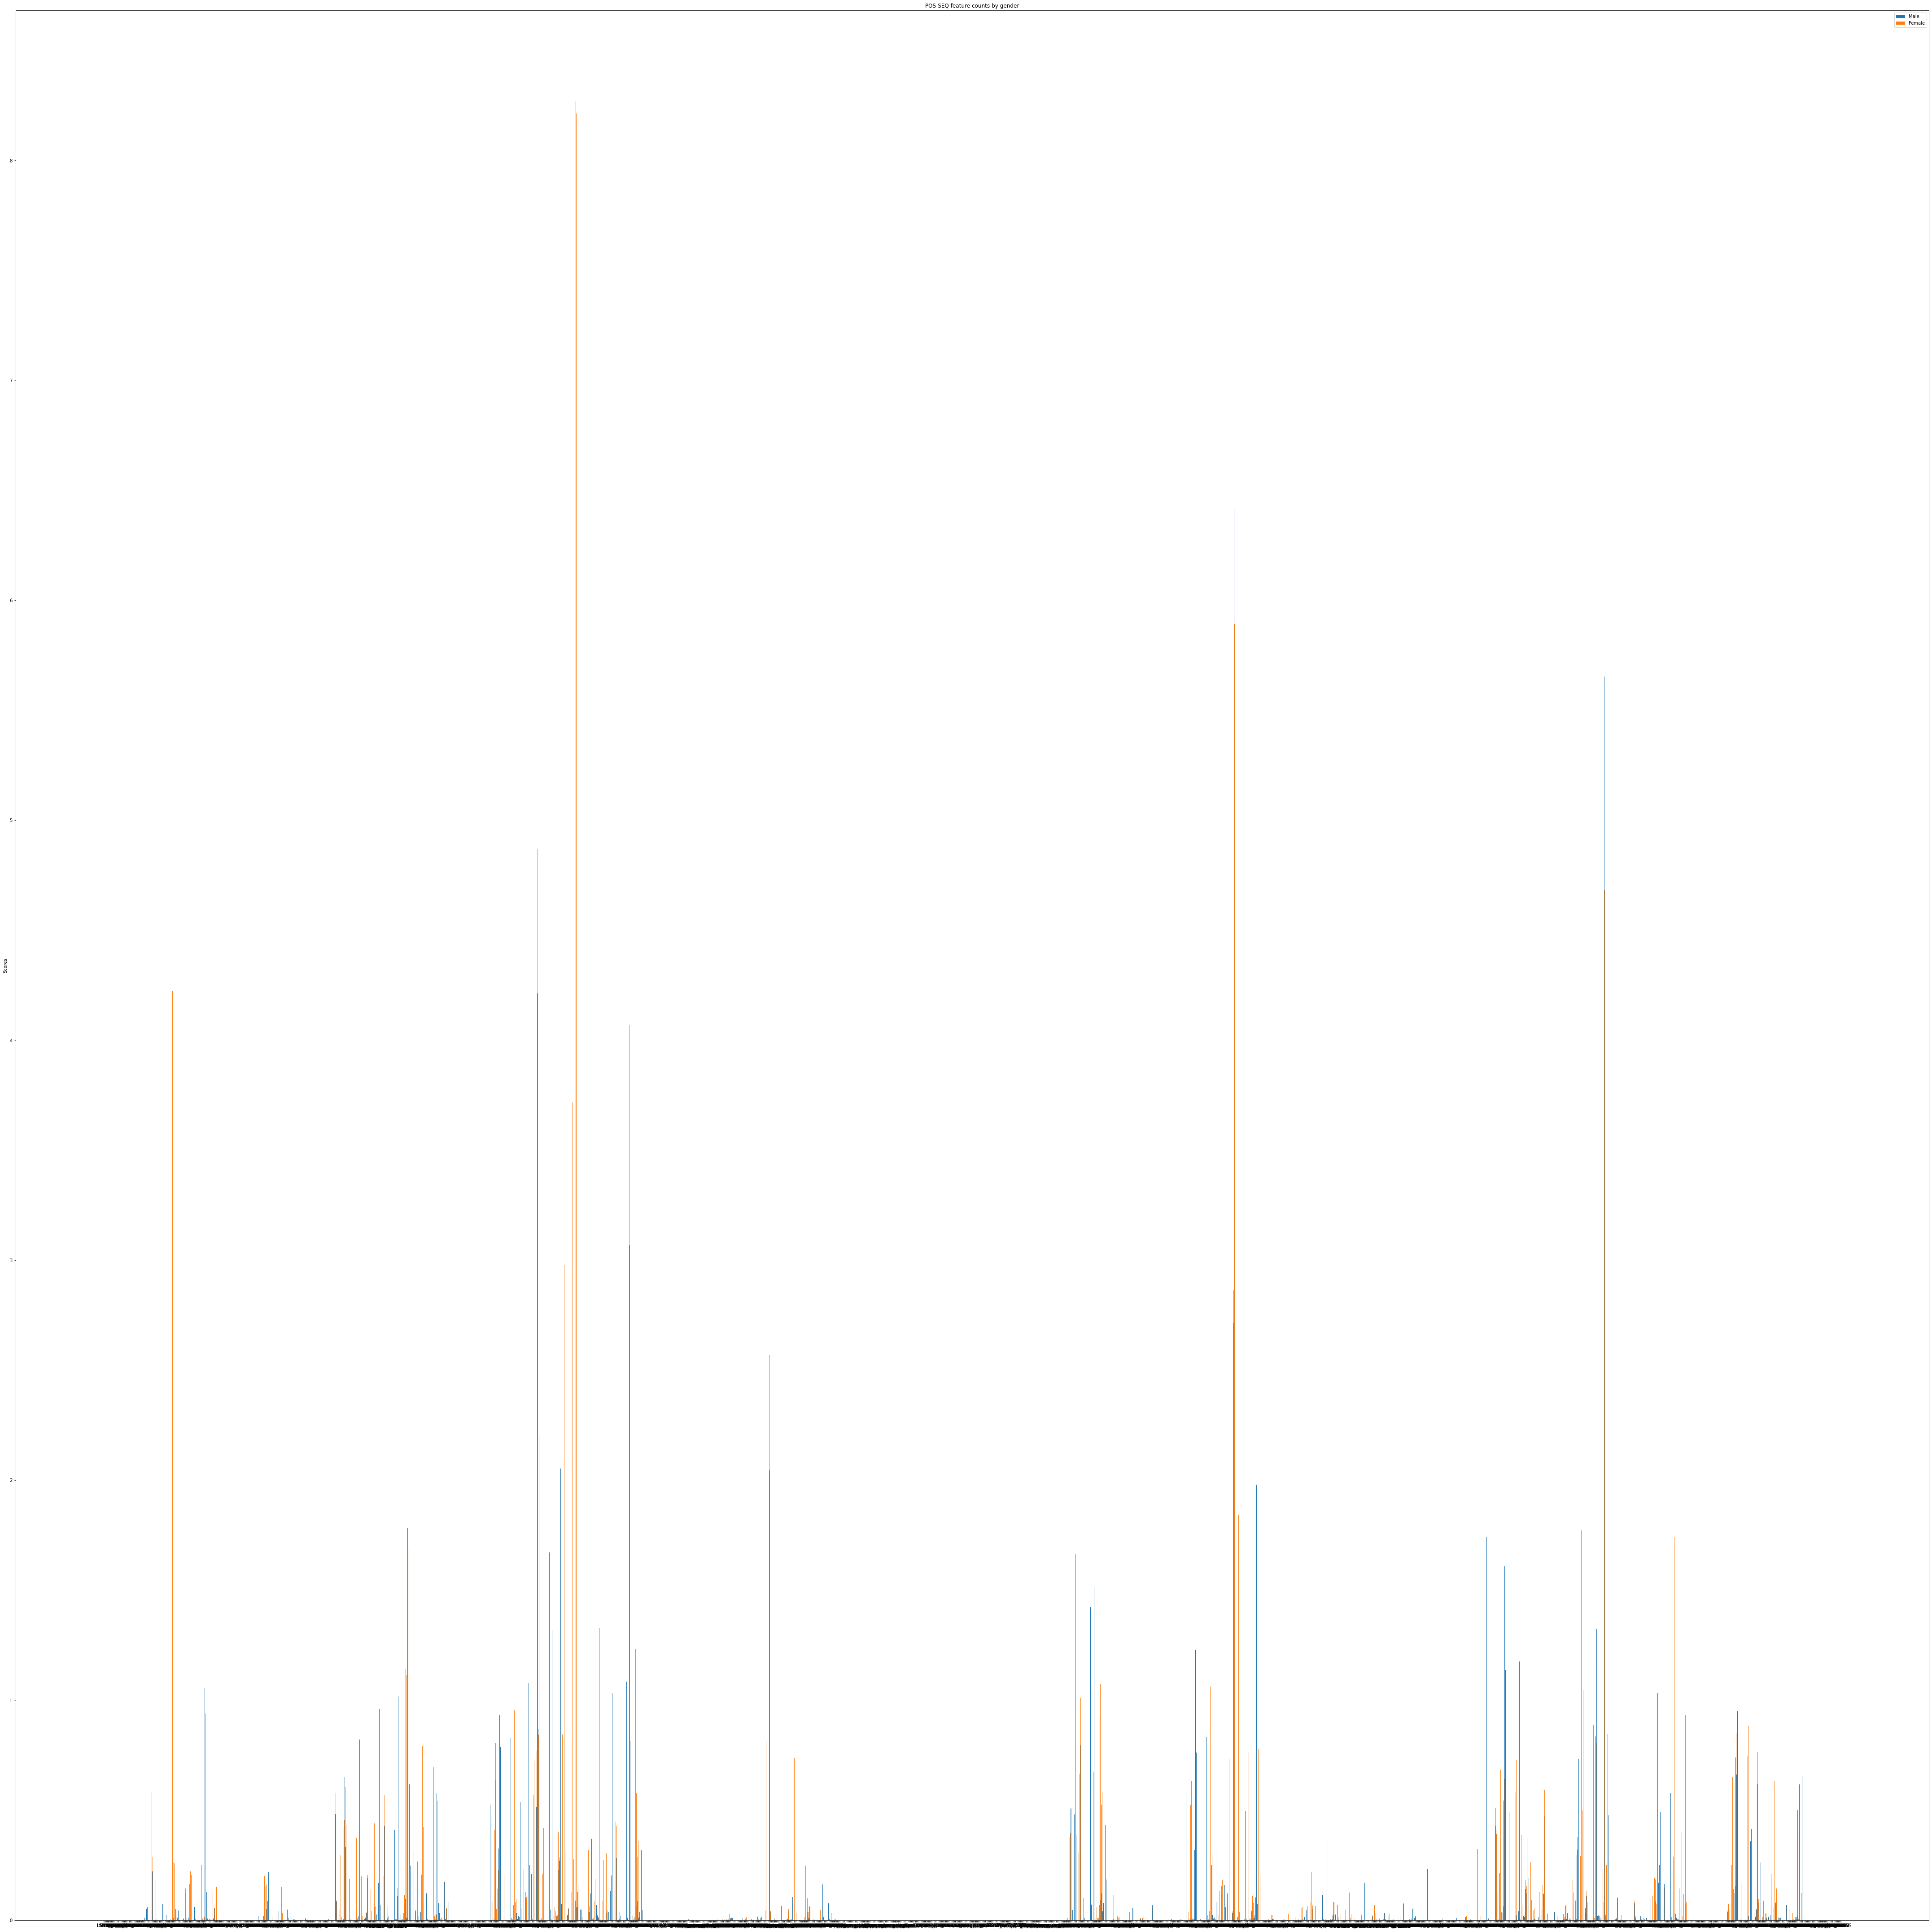

In [42]:
###-------POS-SEQ FEATURES VISUALIZATION (Bigram)----------
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

labels = []
length = len(tagseq)
male_means = np.zeros(length)
female_means = np.zeros(length)

for label in tagseq:
  split_label = label.split()
  new_label = split_label[0]+'-'+split_label[1]
  labels.append(new_label)

male_count = 0
female_count = 0
for idx in range(len(essays)):
  if gender_label[idx] == 0: #male
    male_means += np.asarray(pos_seq_features[idx])
    male_count += 1
  else:
    female_means += np.asarray(pos_seq_features[idx])
    female_count += 1

male_means = male_means/male_count
female_means = female_means/female_count

male_means = list(male_means)
female_means = list(female_means)

create_plot(labels, male_means, female_means, 'POS-SEQ feature counts by gender',0, 60, 1)


In [0]:
###------SVM WITH POS_FEATURES-------
import sklearn
from sklearn import svm
from sklearn.metrics import accuracy_score
classifier = svm.SVC(kernel='rbf')
length = len(pos_features)
trainlength = round(0.8*length)
features = pos_features
Xtrain = np.asarray(features[:trainlength])
Ytrain = np.asarray(gender_label[:trainlength])

#Xtrain = Xtrain.reshape(-1, 1)

classifier.fit(Xtrain, Ytrain)
Xtest = np.asarray(features[trainlength:])
Ytest = np.asarray(gender_label[trainlength:])

#Xtest = Xtest.reshape(-1, 1)

pred = classifier.predict(Xtest)
print(accuracy_score(Ytest, pred))

0.60375


In [0]:
###-----KNN WITH POS_FEATURES---------
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors

length = len(pos_features)
trainlength = round(0.8*length)
features = pos_features
Xtrain = np.asarray(features[:trainlength])
Ytrain = np.asarray(gender_label[:trainlength])

clf = neighbors.KNeighborsClassifier(75)
clf.fit(Xtrain, Ytrain)

Xtest = np.asarray(features[trainlength:])
Ytest = np.asarray(gender_label[trainlength:])

#Xtest = Xtest.reshape(-1, 1)

pred = clf.predict(Xtest)
print(accuracy_score(Ytest, pred))

0.58725


In [0]:
###------SVM WITH POS_SEQ_FEATURES-------
import sklearn
from sklearn import svm
from sklearn.metrics import accuracy_score
classifier = svm.SVC(kernel='rbf')
length = len(pos_features)
trainlength = round(0.8*length)
features = pos_seq_features
Xtrain = np.asarray(features[:trainlength])
Ytrain = np.asarray(gender_label[:trainlength])

#Xtrain = Xtrain.reshape(-1, 1)

classifier.fit(Xtrain, Ytrain)
Xtest = np.asarray(features[trainlength:])
Ytest = np.asarray(gender_label[trainlength:])

#Xtest = Xtest.reshape(-1, 1)

pred = classifier.predict(Xtest)
print(accuracy_score(Ytest, pred))

0.5975


In [0]:
###-----KNN WITH POS_FEATURES---------
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors

length = len(essays)
trainlength = round(0.8*length)
features = pos_seq_features
Xtrain = np.asarray(features[:trainlength])
Ytrain = np.asarray(gender_label[:trainlength])

clf = neighbors.KNeighborsClassifier(75)
clf.fit(Xtrain, Ytrain)

Xtest = np.asarray(features[trainlength:])
Ytest = np.asarray(gender_label[trainlength:])

#Xtest = Xtest.reshape(-1, 1)

pred = clf.predict(Xtest)
print(accuracy_score(Ytest, pred))

In [0]:
###-------CREATING NGRAM FEATURES-----------
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def ngram_train(data, num):
  count_vect = CountVectorizer(stop_words='english', analyzer='word', ngram_range=(num, num))
  ngram_counts = count_vect.fit_transform(data)
  return ngram_counts, count_vect

def ngram_test(data, model):
  ngram_counts = model.transform(data)
  return ngram_counts

#tfidf_transformer = TfidfTransformer()
#tfidf_features = tfidf_transformer.fit_transform(original_data)
#tfidf_features.shape

In [44]:
###----CREATING POS NGRAMS--------------
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
tagset = nltk.load('help/tagsets/upenn_tagset.pickle')
no_tags = len(tagset.keys())

def pos_cvt(data):
  pos_essays = []
  for post in data:
    pos = nltk.pos_tag(post)
    new_pos = [elem[1] for elem in pos]
    pos_essays.append(' '.join(new_pos))
  return pos_essays

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [3]:
###---------ORIGINAL NGRAMS------------
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

trainlength = round(0.8*len(essays))
features = original_data

Xtrain = np.asarray(features[0:trainlength])
Ytrain = np.asarray(gender_label[0:trainlength])
Xtest = np.asarray(features[trainlength:])
Ytest = np.asarray(gender_label[trainlength:])

train_data, model = ngram_train(Xtrain, 1) 
test_data = ngram_test(Xtest, model)
print(Xtrain.shape, Ytrain.shape,train_data.shape)

nb_classifier = MultinomialNB().fit(train_data, Ytrain)
pred = nb_classifier.predict(test_data)
print(accuracy_score(Ytest, pred))


(16000,) (16000,) (16000, 85495)
0.6405


In [0]:
###-------POS NGRAMS------------
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

trainlength = round(0.8*len(essays))
features = pos_cvt(original_data)

Xtrain = np.asarray(features[0:trainlength])
Ytrain = np.asarray(gender_label[0:trainlength])
Xtest = np.asarray(features[trainlength:])
Ytest = np.asarray(gender_label[trainlength:])

train_data, model = ngram_train(Xtrain) 
test_data = ngram_test(Xtest, model)
print(Xtrain.shape, Ytrain.shape,train_data.shape)

nb_classifier = MultinomialNB().fit(train_data, Ytrain)
pred = nb_classifier.predict(test_data)
print(accuracy_score(Ytest, pred))

In [5]:
###-------NGRAM FEATURES VISUALIZATION (Bigram)----------
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

labels = []
ff = model.get_feature_names()
length = len(ff)
male_means = np.zeros(length)
female_means = np.zeros(length)

for label in ff:
  labels.append(label)

male_count = 0
female_count = 0
for idx in range(len(Xtrain)):
  if gender_label[idx] == 0: #male
    male_means += np.asarray(train_data[idx])
    male_count += 1
  else:
    female_means += np.asarray(train_data[idx])
    female_count += 1

male_means = male_means/male_count
female_means = female_means/female_count

male_means = list(male_means)
female_means = list(female_means)

create_plot(labels, male_means, female_means, 'POS-SEQ feature counts by gender',0, 60, 0)

TypeError: ignored

In [0]:
from sklearn import svm
from sklearn.metrics import accuracy_score

trainlength = round(0.8*len(essays))
features = original_data

Xtrain = np.asarray(features[0:trainlength])
Ytrain = np.asarray(gender_label[0:trainlength])
Xtest = np.asarray(features[trainlength:])
Ytest = np.asarray(gender_label[trainlength:])

train_data, model = ngram_train(Xtrain) 
test_data = ngram_test(Xtest, model)

classifier = svm.SVC(kernel='rbf')
classifier.fit(train_data, Ytrain)
pred = classifier.predict(test_data)
print(accuracy_score(Ytest, pred))

0.6295


In [0]:
###-----CREATING NGRAMS FEATURES---------
import nltk.util
from nltk.util import ngrams
from collections import Counter

count_feat = []
for post in essays:
  unigrams = nltk.ngrams(post,1)
  counts = Counter(unigrams)
  count_feat.append(counts)

#male_fd = nltk.FreqDist(male_unigrams)
#female_fd = nltk.FreqDist(female_unigrams)

In [0]:
print(train_data.shape, test_data.shape, Ytrain.shape, Ytest.shape)

(16000, 85495) (4000, 39850) (16000,) (4000,)


[ 0.  1.  0.  0.  0.  0.  1.  4.  1.  0.  1. 11.  6.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  8.  1.  0.  0.  2.  1.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  1.  0.  2.  0.  0.] 41
